# libcbm run of tutorial 2 from CBM-CFS3

In [1]:
import os, json
import pandas as pd
%matplotlib inline

Import the required packages from libcbm
 
    - sit_cbm_factory: a module for initializing the CBM model from the CBM Standard import tool format
    - cbm_simulator: simulates the sit dataset using the CBM model
    - libcbm.resources: gets files for tutorial 2 that are bundled in libcbm


In [2]:
from libcbm.input.sit import sit_cbm_factory
from libcbm.model.cbm import cbm_simulator
from libcbm import resources

## Setup
Load the standard import tool configuration at the specified path.  This configuration encompasses the data source for the various sit inputs (sit_inventory, sit_classifiers etc.) and also the relationships of classifiers, and disturbance types to the default CBM parameters.

In [3]:
config_path = os.path.join(resources.get_test_resources_dir(), "cbm3_tutorial2", "sit_config.json")
sit = sit_cbm_factory.load_sit(config_path)

Initialize and validate the inventory in the sit dataset

In [4]:
classifiers, inventory = sit_cbm_factory.initialize_inventory(sit)

Initialize an instance of the CBM model

In [5]:
cbm = sit_cbm_factory.initialize_cbm(sit)

Create storage and a function for storing CBM simulation results.  This particular implementation appends timestep results for each step into a running DataFrame which is stored in memory.

In [6]:
results, reporting_func = cbm_simulator.create_in_memory_reporting_func()

Create a function to apply rule based disturbance events and transition rules based on the SIT input

In [7]:
rule_based_event_func = sit_cbm_factory.create_sit_rule_based_pre_dynamics_func(sit, cbm, lambda x: None)

## Simulation
The following line of code spins up the CBM inventory and runs it through 100 timesteps. 

In [8]:
cbm_simulator.simulate(
    cbm,
    n_steps              = 200,
    classifiers          = classifiers,
    inventory            = inventory,
    pool_codes           = sit.defaults.get_pools(),
    flux_indicator_codes = sit.defaults.get_flux_indicators(),
    pre_dynamics_func    = rule_based_event_func,
    reporting_func       = reporting_func
)

## Pool Results

In [9]:
pi = results.pool_indicators

In [10]:
pi.head()

,identifier,timestep,Input,SoftwoodMerch,SoftwoodFoliage,SoftwoodOther,SoftwoodCoarseRoots,SoftwoodFineRoots,HardwoodMerch,HardwoodFoliage,...,BelowGroundSlowSoil,SoftwoodStemSnag,SoftwoodBranchSnag,HardwoodStemSnag,HardwoodBranchSnag,CO2,CH4,CO,NO2,Products
0,1,0,200.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,10529.242115,5568.605479,1544.809522,0.0,0.0,690032.809697,631.259013,5681.261733,0.0,0.0
1,2,0,100.0,0.003124,0.376897,0.0,0.048428,0.035936,0.0,0.0,...,5273.531854,2666.157167,666.417417,0.0,0.0,345255.294728,315.629506,2840.630866,0.0,0.0
2,3,0,100.0,0.030782,1.867345,0.0,0.241950,0.179434,0.0,0.0,...,5278.708266,2553.024910,574.973378,0.0,0.0,345471.445778,315.629506,2840.630866,0.0,0.0
3,4,0,100.0,0.117354,4.744316,0.0,0.620009,0.459282,0.0,0.0,...,5281.125622,2444.693447,496.077048,0.0,0.0,345669.654559,315.629506,2840.630866,0.0,0.0
4,5,0,100.0,0.303283,9.168135,0.0,1.208806,0.893849,0.0,0.0,...,5281.488695,2340.959458,428.006664,0.0,0.0,345853.464520,315.629506,2840.630866,0.0,0.0


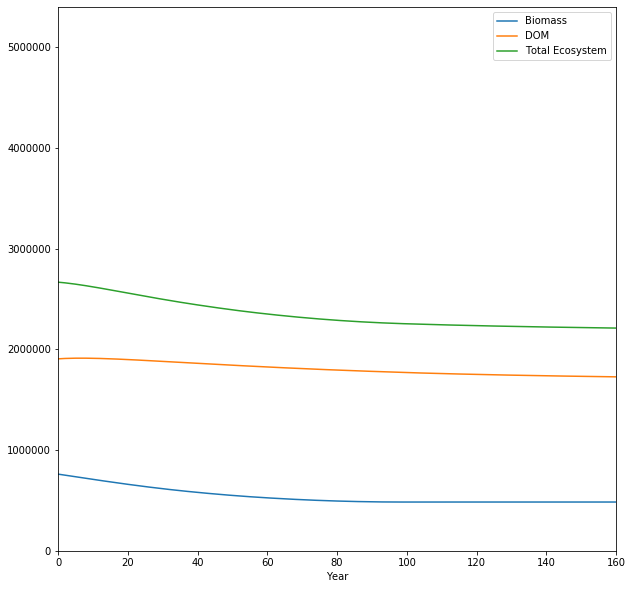

In [11]:
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots', 'SoftwoodFineRoots',
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']

dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']

biomass_result = pi[['timestep']+biomass_pools]
dom_result = pi[['timestep']+dom_pools]
total_eco_result = pi[['timestep']+biomass_pools+dom_pools]

annual_carbon_stocks = pd.DataFrame(
    {
        "Year": pi["timestep"],
        "Biomass": pi[biomass_pools].sum(axis=1),
        "DOM": pi[dom_pools].sum(axis=1),
        "Total Ecosystem": pi[biomass_pools+dom_pools].sum(axis=1)})

annual_carbon_stocks.groupby("Year").sum().plot(figsize=(10,10),xlim=(0,160),ylim=(0,5.4e6))

## State Variable Results

In [34]:
si = results.state_indicators

In [35]:
si.head()

,identifier,timestep,last_disturbance_type,time_since_last_disturbance,time_since_land_class_change,growth_enabled,enabled,land_class,age,growth_multiplier,regeneration_delay
0,1,0,1,0,-1,1,1,0,0,1.0,0
1,2,0,1,1,-1,1,1,0,1,1.0,0
2,3,0,1,2,-1,1,1,0,2,1.0,0
3,4,0,1,3,-1,1,1,0,3,1.0,0
4,5,0,1,4,-1,1,1,0,4,1.0,0


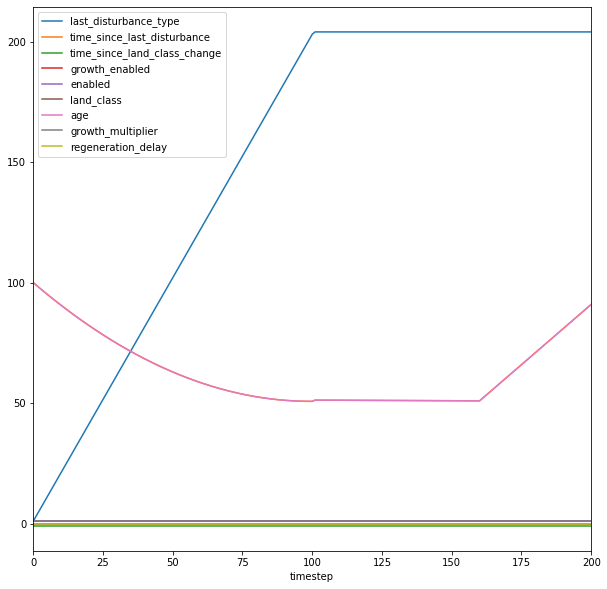

In [45]:
state_variables = ['timestep','last_disturbance_type', 'time_since_last_disturbance', 'time_since_land_class_change',
 'growth_enabled', 'enabled', 'land_class', 'age', 'growth_multiplier', 'regeneration_delay']
si[state_variables].groupby('timestep').mean().plot(figsize=(10,10))

## Flux Indicators

In [46]:
fi = results.flux_indicators

In [47]:
fi.head()

,identifier,timestep,DisturbanceCO2Production,DisturbanceCH4Production,DisturbanceCOProduction,DisturbanceBioCO2Emission,DisturbanceBioCH4Emission,DisturbanceBioCOEmission,DecayDOMCO2Emission,DisturbanceSoftProduction,...,DisturbanceVFastBGToAir,DisturbanceFastAGToAir,DisturbanceFastBGToAir,DisturbanceMediumToAir,DisturbanceSlowAGToAir,DisturbanceSlowBGToAir,DisturbanceSWStemSnagToAir,DisturbanceSWBranchSnagToAir,DisturbanceHWStemSnagToAir,DisturbanceHWBranchSnagToAir
0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,477.779759,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,0.0,0.0,0.0,0.0,0.0,0.0,216.151050,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,0.0,0.0,0.0,0.0,0.0,0.0,198.208781,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1,0.0,0.0,0.0,0.0,0.0,0.0,183.809961,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1,0.0,0.0,0.0,0.0,0.0,0.0,172.067859,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir']


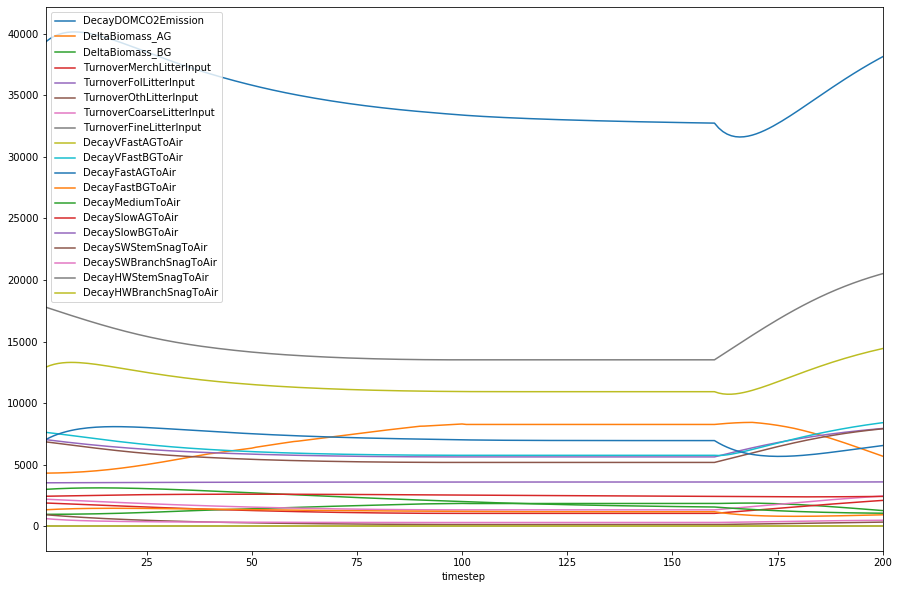

In [49]:
fi[["timestep"]+annual_process_fluxes].groupby("timestep").sum().plot(figsize=(15,10))

## Appendix

### SIT source data

In [50]:
sit.sit_data.age_classes

,name,class_size,start_year,end_year
0,AGEID0,0,0,0
1,AGEID1,10,1,10
2,AGEID2,10,11,20
3,AGEID3,10,21,30
4,AGEID4,10,31,40
5,AGEID5,10,41,50
6,AGEID6,10,51,60
7,AGEID7,10,61,70
8,AGEID8,10,71,80
9,AGEID9,10,81,90


In [51]:
sit.sit_data.inventory

,Working Species Or Leading Species,Site Quality,Density Class,Working Status,age,area,delay,land_class,historical_disturbance_type,last_pass_disturbance_type
0,BF,GOOD,D1,W,0,200.0,0,0,Natural forest fire,Natural forest fire
1,BF,GOOD,D1,W,1,100.0,0,0,Natural forest fire,Natural forest fire
2,BF,GOOD,D1,W,2,100.0,0,0,Natural forest fire,Natural forest fire
3,BF,GOOD,D1,W,3,100.0,0,0,Natural forest fire,Natural forest fire
4,BF,GOOD,D1,W,4,100.0,0,0,Natural forest fire,Natural forest fire
...,...,...,...,...,...,...,...,...,...,...
196,BF,GOOD,D1,W,196,100.0,0,0,Natural forest fire,Natural forest fire
197,BF,GOOD,D1,W,197,100.0,0,0,Natural forest fire,Natural forest fire
198,BF,GOOD,D1,W,198,100.0,0,0,Natural forest fire,Natural forest fire
199,BF,GOOD,D1,W,199,100.0,0,0,Natural forest fire,Natural forest fire


In [52]:
sit.sit_data.classifiers

,id,name
0,1,Working Species Or Leading Species
10,2,Site Quality
14,3,Density Class
20,4,Working Status


In [53]:
sit.sit_data.classifier_values

,classifier_id,name,description
1,1,BF,Balsam Fir
2,1,BS,Black Spruce
3,1,JL,Western Larch
4,1,JP,Jack Pine
5,1,OS,Other Spruce
6,1,RP,Red Pine
7,1,SH,Unspecified Softwood
8,1,LT,Larch
9,1,WS,White Spruce
11,2,GOOD,Good


In [54]:
sit.sit_data.disturbance_types

,id,name
0,DISTID1,Natural forest fire
1,DISTID2,Senescence
2,DISTID3,Mountain pine beetle infestation
3,DISTID4,ClearCut Harvesting


In [55]:
sit.sit_data.yield_table

,Working Species Or Leading Species,Site Quality,Density Class,Working Status,leading_species,v0,v1,v2,v3,v4,...,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20
0,BF,GOOD,D1,W,29,0.0,0.0,0.0,8.0,20.0,...,112.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0


In [56]:
print(json.dumps(sit.config, indent=4, sort_keys=True))

{
    "import_config": {
        "age_classes": {
            "params": {
                "path": "age_classes.csv"
            },
            "type": "csv"
        },
        "classifiers": {
            "params": {
                "path": "classifiers.csv"
            },
            "type": "csv"
        },
        "disturbance_types": {
            "params": {
                "path": "disturbance_types.csv"
            },
            "type": "csv"
        },
        "events": {
            "params": {
                "path": "disturbance_events.csv"
            },
            "type": "csv"
        },
        "inventory": {
            "params": {
                "path": "inventory.csv"
            },
            "type": "csv"
        },
        "transitions": {
            "params": {
                "path": "transition_rules.csv"
            },
            "type": "csv"
        },
        "yield": {
            "params": {
                "path": "growth_and_yield.csv"
            